<a href="https://colab.research.google.com/github/t108368071/MyProject/blob/master/LSTM_SBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
from google.colab import drive 

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/
df_all = pd.read_csv("NormalBP_features_60000.csv") 
#df_all = pd.read_csv("NormalBP_features_13000.csv") 
#df_all = pd.read_csv("HIGHBP_features_13000.csv")
#df_all = pd.read_csv("LOWBP_features_13000.csv")
#df_all = pd.read_csv("MIXBP_features_39000.csv")

#num_features = ['cardiac_period', 'SUT', 'DT', 'DW_10', 'DW_25', 'DW_33', 'DW_50', 'DW_66','DW_75', 'SW_10 + DW_10', 'SW_10/DW_10', 'SW_25 + DW_25', 'SW_25/DW_25', 'SW_33 + DW_33', 'SW_33/DW_33','SW_50 + DW_50', 'SW_50 / DW_50', 'SW_66 + DW_66', 'SW_66 / DW_66','SW_75 + DW_75', 'SW_75 / DW_75','area','area_s','area_d']

#正常特徵
num_features = ['cardiac_period', 'SUT', 'DT','SW_25 + DW_25','SW_75 + DW_75','DW_50','SW_50 + DW_50','area_d']

#高血壓特徵
#num_features = ['cardiac_period','DT','area_d','area_s','SW_50 + DW_50','DW_33','SW_33/DW_33','SW_10/DW_10']

#低血壓特徵
#num_features = ['cardiac_period','DT','area_d','area_s','SUT','area','SW_10/DW_10','SW_25/DW_25']

#混和特徵
#num_features = ['cardiac_period','SUT', 'DT','DW_50','SW_75 / DW_75','area_d','DW_75', 'SW_10/DW_10']

#target = ['diastolic']
#target = ['systolic']

data = df_all[num_features]
data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


,cardiac_period,SUT,DT,SW_25 + DW_25,SW_75 + DW_75,DW_50,SW_50 + DW_50,area_d
0,70,17,54,36,15,14,22,0.741239
1,71,17,53,36,16,14,24,0.712137
2,70,18,53,36,17,14,24,0.679953
3,71,17,54,36,16,14,23,0.692348
4,70,17,53,41,17,15,24,0.711011


In [13]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScaler
#sc=StandardScaler()
#data=sc.fit_transform(data)

def normalize(train):
  train_norm = train.apply(lambda x: (x - np.mean(x)) / np.std(x) )
  return train_norm

data = normalize(data)

data.head()

,cardiac_period,SUT,DT,SW_25 + DW_25,SW_75 + DW_75,DW_50,SW_50 + DW_50,area_d
0,-1.822381,-1.038199,-1.602467,-1.112255,-0.755647,-0.848281,-1.009680,-1.348619
1,-1.709881,-1.038199,-1.757179,-1.112255,-0.481255,-0.848281,-0.692509,-1.642610
2,-1.822381,-0.808591,-1.757179,-1.112255,-0.206862,-0.848281,-0.692509,-1.967727
3,-1.709881,-1.038199,-1.602467,-1.112255,-0.481255,-0.848281,-0.851095,-1.842515
4,-1.822381,-1.038199,-1.757179,-0.602721,-0.206862,-0.600026,-0.692509,-1.653986


In [14]:
target = ['systolic','diastolic']
df_target = df_all[target]
df_target.head()

,systolic,diastolic
0,136.372739,65.402256
1,122.940610,66.672202
2,122.110261,66.379138
3,120.889158,65.060347
4,119.033082,66.623358


In [15]:
new_data = pd.concat([data, df_target],axis=1)
new_data.head

<bound method NDFrame.head of        cardiac_period       SUT        DT  ...    area_d    systolic  diastolic
0           -1.822381 -1.038199 -1.602467  ... -1.348619  136.372739  65.402256
1           -1.709881 -1.038199 -1.757179  ... -1.642610  122.940610  66.672202
2           -1.822381 -0.808591 -1.757179  ... -1.967727  122.110261  66.379138
3           -1.709881 -1.038199 -1.602467  ... -1.842515  120.889158  65.060347
4           -1.822381 -1.038199 -1.757179  ... -1.653986  119.033082  66.623358
...               ...       ...       ...  ...       ...         ...        ...
60375       -0.697383 -1.267807 -0.210065  ... -0.365686   99.886193  72.875404
60376       -0.697383 -1.038199 -0.055353  ...  0.262783   99.104688  72.289274
60377       -0.697383 -1.267807 -0.210065  ... -0.272784   97.688209  72.191586
60378       -0.809883 -1.038199 -0.364776  ... -0.544380   96.467106  72.680027
60379       -0.922383 -1.038199 -0.364776  ... -0.532964   97.541676  73.412689

[60380 ro

In [16]:
def buildTrain(train, pastDay=5, futureDay=1):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][["systolic","diastolic"]]))
  return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]


def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [17]:
# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(new_data, 10, 1)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.3)
X_val, Y_val, X_test, Y_test = splitData(X_val, Y_val, 0.5)

In [18]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(42259, 10, 10)
(42259, 1, 2)
(9055, 10, 10)
(9055, 1, 2)
(9055, 10, 10)
(9055, 1, 2)


In [19]:
Y_train=Y_train.reshape(42259,2)
Y_val=Y_val.reshape(9055,2)
Y_test=Y_test.reshape(9055,2)

In [20]:
def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(128, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(256))
  model.add(Dense(2))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [21]:
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=150,  verbose=1, mode='min')
model.fit(X_train, Y_train, epochs=500, batch_size=64, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           71168     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 465,922
Trainable params: 465,922
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
661/661 [==============================] - 38s 7ms/step - loss: 3827.4903 - val_loss: 112.9298
Epoch 2/500
661/661 [==============================] - 4s 6ms/step - loss: 96.2738 - val_loss: 89.4771
Epoch 3/500
661/661 [=================

[[133.22609   73.742424]
 [130.63286   65.12957 ]
 [134.47183   70.49189 ]
 ...
 [134.403     81.96348 ]
 [117.24784   68.36681 ]
 [112.89902   61.106487]]
MAE SBP: 2.027965319436538 SD:2.731219618563765 MAE DBP: 1.3887487083121626 SD:1.6070974554551567


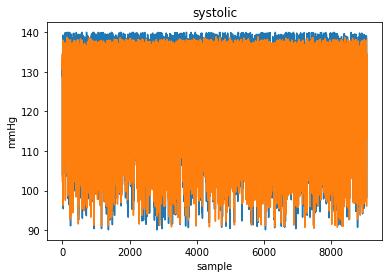

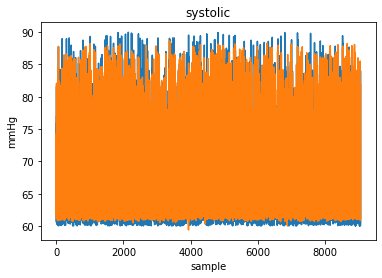

In [22]:
testPredict = model.predict(X_test)
print(testPredict)
from sklearn.metrics import mean_absolute_error
mae_error_sbp = mean_absolute_error(testPredict[:,0],Y_test[:,0])
mae_error_dbp = mean_absolute_error(testPredict[:,1],Y_test[:,1])

error_sbp_std = np.std(abs(testPredict[:,0] - Y_test[:,0])) 
error_dbp_std = np.std(abs(testPredict[:,1] - Y_test[:,1])) 

print(f"MAE SBP: {mae_error_sbp} SD:{error_sbp_std} MAE DBP: {mae_error_dbp} SD:{error_dbp_std}")

plt.figure(1)
plt.title("systolic")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(Y_test[:,0])
plt.plot(testPredict[:,0])

plt.figure(2)
plt.title("systolic")
plt.xlabel("sample") 
plt.ylabel("mmHg")
plt.plot(Y_test[:,1])
plt.plot(testPredict[:,1])